<a href="https://colab.research.google.com/github/phuocnguyen90/JobAnalysis/blob/main/data_job_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Introduction


This project aims to find a correlation between job descriptions, skills and job title.

We will focus on the following jobs: Data Scientist- Data Analyst - Data Engineer - Business Analyst - Business Intelligence

I. Introduction
1. [Dataset overview](#Info)

2. [EDA](#EDA)

3. [Preprocess some data](#Preprocess)

II. Data analysis

1. [Extract skills from job description - NLP](#II1)

  [ Skills overview](#II11)

  [Skills per job category](#II12)

  [Helper functions](#II13)

  [Visualize skills by job category](#II14)

2. [Job position from job description - multiple label regression](#II2)
  
  [MultinominalNB](NB)

  [Binary relevance](#BinaryRelevance)

  [Random Forest](RF)


3. Neural networks application
  1. [Convoluted Neural Network](#CNN)
  2. [Salary prediction](#Salary)


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

In [2]:
!pip install fasttext
!pip install spacy
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=017c18ff9fff94b78bfa56305eea323d9db62734399647754f580aab68242e3b
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
2023-10-27 07:46:40.857322: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 07:46:40.857385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 07:46:40.857412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Un

In [3]:
#additional libraries for experimenting with NLP
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import fasttext
import spacy
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [4]:
# Load spaCy model (pre-trained word embeddings)
nlp = spacy.load('en_core_web_md')


# <a name="Info">Data info</a>

The following job dataset was extracted from an [spreadsheet file](https://docs.google.com/spreadsheets/d/1xWtdPaEmi6Voaum_3Ruv-Ise0SKaxVSrs5G2a0V8PLA/edit#gid=0), which contains job posting mined from different job boards and social network posts in Vietnam.

The dataset was processed manually using Excel, but there are still inconsistencies.

This dataset contains 3188 job postings, which originally contains 9 columns and was aggregated into 34 columns. Job descriptions were translated by Google, with minor manual editing.

Some orignal data was aggregated for one-hot encoding: Experience level (L1-L4, MinL), Location (indices 14-19), Job term (indices 22-26), Job category (indices 27-33)

**Important: Job category columns were manually labelled based on Job Title**


In [5]:
test = pd.read_csv('Data_Jobs.csv', encoding='Windows-1252')

#  <a name="EDA">EDA</a>




In [6]:
test.info()
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3187 entries, 0 to 3186
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Job_ID                 3187 non-null   int64  
 1   Job_Title              3187 non-null   object 
 2   Min_YOE                2567 non-null   float64
 3   Est_Salary             3041 non-null   float64
 4   JD_Trans               3187 non-null   object 
 5   L1                     3173 non-null   float64
 6   L2                     1441 non-null   object 
 7   L3                     32 non-null     float64
 8   L4                     1 non-null      float64
 9   MinL                   3187 non-null   int64  
 10  Location               3174 non-null   object 
 11  VN                     3187 non-null   int64  
 12  Remote                 3187 non-null   int64  
 13  W_Term                 3187 non-null   object 
 14  W_Term_2               326 non-null    object 
 15  W_Te

,Job_ID,Job_Title,Min_YOE,Est_Salary,JD_Trans,L1,L2,L3,L4,MinL,...,W_Term_2,W_Term_3,W_Term_4,Data_Engineer,Data_Analyst,Data_Scientist,Business_Analyst,Business_Intelligence,Combined_role,Others
0,5603,Senior Machine Learning,3.0,3390.0,Lang Ha Earable recruits Senior ML from 3 ++ y...,2.0,NaN,NaN,NaN,2,...,NaN,NaN,NaN,1,0,1,0,0,1,0
1,5602,Data Engineer,1.0,1270.0,HN-LLLL; Product Company recruits #data #engin...,1.0,2,NaN,NaN,1,...,NaN,NaN,NaN,1,0,0,0,0,0,0
2,5601,AI Research Engineer,3.0,2755.0,Cau Giay - HN - AI Research Engineer - 3-7year...,2.0,NaN,NaN,NaN,2,...,NaN,NaN,NaN,1,0,1,0,0,1,0
3,5600,Data Analyst,3.0,1270.0,Over 3 years of experience in data analysis.,2.0,NaN,NaN,NaN,2,...,NaN,NaN,NaN,0,1,0,0,0,0,0
4,5599,Data Engineer,2.0,1800.0,From 2 years of experience that has been worki...,1.0,NaN,NaN,NaN,1,...,NaN,NaN,NaN,1,0,0,0,0,0,0


#  <a name="Preprocess">Preprocess job description data</a>
The dataset was copy and pasted directly from the original source in Vietnamese. Some preprocessing were done in Excel, including translation of the Job description to English using Google Translate and can contain redundant parts.

In this step, we will try to extract only the relevant skills
* Convert all text to lower cases
* Delete all tabulation,spaces, and new lines
* Delete nltk's defined stop words
* Lemmatize text

In [7]:
test['JD_Trans'] = test['JD_Trans'].astype(str)
## Lower case
test['JD_Trans'] = test['JD_Trans'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test['JD_Trans'] = test['JD_Trans'].str.replace('[^\w\s]',' ')
## digits
test['JD_Trans'] = test['JD_Trans'].str.replace('\d+', '')
#remove stop words
stop = stopwords.words('english')
test['JD_Trans'] = test['JD_Trans'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
## lemmatization
test['JD_Trans'] = test['JD_Trans'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Limit years of experience to a maximum of 10
test['Min_YOE'] = test['Min_YOE'].apply(lambda x: min(x, 10))

# Remove the outlier jobs that have Est_Salary larger than $10,000
test['Est_Salary'] = test['Est_Salary'].apply(lambda x: min(x, 10000))

print("Preprocessed data: \n")
print(test.head(5))

<ipython-input-7-cf4fed3628e9>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test['JD_Trans'] = test['JD_Trans'].str.replace('[^\w\s]',' ')
<ipython-input-7-cf4fed3628e9>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  test['JD_Trans'] = test['JD_Trans'].str.replace('\d+', '')


Preprocessed data: 

   Job_ID                Job_Title  Min_YOE  Est_Salary  \
0    5603  Senior Machine Learning      3.0      3390.0   
1    5602            Data Engineer      1.0      1270.0   
2    5601     AI Research Engineer      3.0      2755.0   
3    5600             Data Analyst      3.0      1270.0   
4    5599            Data Engineer      2.0      1800.0   

                                            JD_Trans   L1   L2  L3  L4  MinL  \
0  lang ha earable recruit senior ml year experie...  2.0  NaN NaN NaN     2   
1  hn llll product company recruit data engineer ...  1.0    2 NaN NaN     1   
2  cau giay hn ai research engineer year experien...  2.0  NaN NaN NaN     2   
3                      year experience data analysis  2.0  NaN NaN NaN     2   
4  year experience working data engineer position...  1.0  NaN NaN NaN     1   

   ... W_Term_2  W_Term_3  W_Term_4 Data_Engineer Data_Analyst Data_Scientist  \
0  ...      NaN       NaN       NaN             1            0

**Let's visualize the job categories in this dataset**
Unsurprisingly, Data engineer and Data analyst jobs are the most frequently seen job on the job boards


Category: Data_Engineer, Count: 1059
Category: Data_Analyst, Count: 1051
Category: Data_Scientist, Count: 447
Category: Business_Analyst, Count: 220
Category: Business_Intelligence, Count: 185
Category: Others, Count: 622
Category Counts: [1059, 1051, 447, 220, 185, 622]


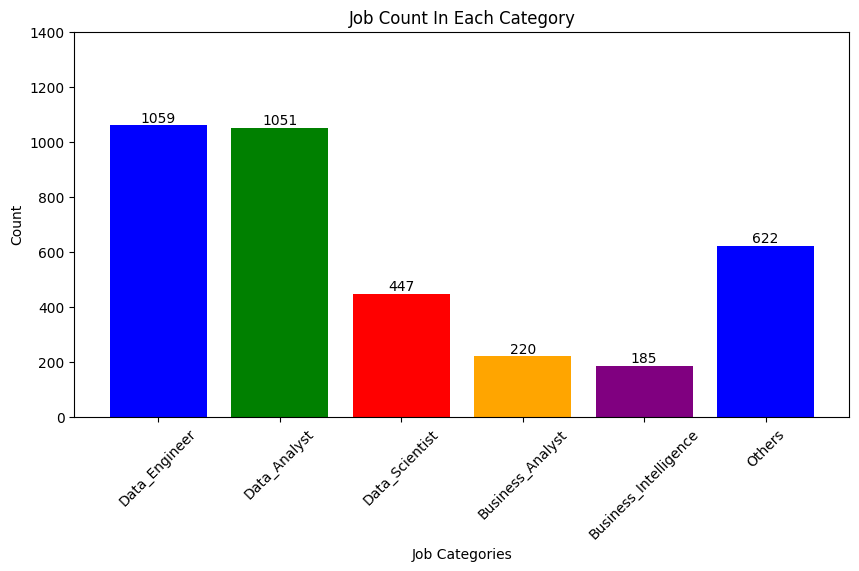

In [8]:
import matplotlib.pyplot as plt

# List of job categories
job_categories = ['Data_Engineer', 'Data_Analyst', 'Data_Scientist', 'Business_Analyst', 'Business_Intelligence','Others']

# Create a list to store the counts of each job category
category_counts = []

# Count the number of occurrences for each job category
for category in job_categories:
    count = test[category].sum()
    print(f'Category: {category}, Count: {count}')
    category_counts.append(count)

# Print the list of counts
print("Category Counts:", category_counts)
colors = ['blue', 'green', 'red', 'orange', 'purple']
# Create a histogram
plt.figure(figsize=(10, 5))
plt.bar(job_categories, category_counts, color = colors)
for i, value in enumerate(category_counts):
    plt.text(i, category_counts[i], str(category_counts[i]), ha='center', va='bottom')
plt.ylim(0, 1400)
plt.xlabel('Job Categories')
plt.ylabel('Count')
plt.title('Job Count In Each Category')
plt.xticks(rotation=45)
plt.show()


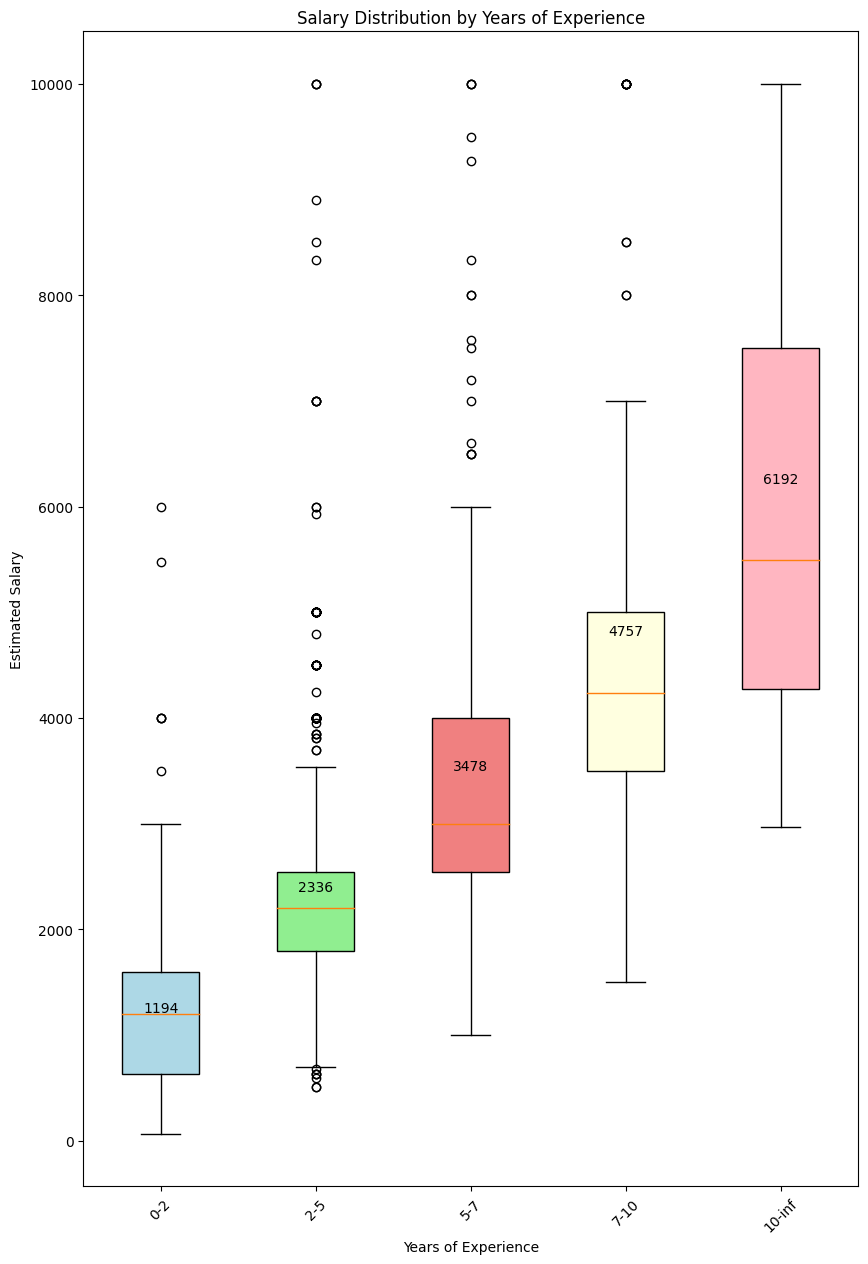

In [9]:
# Define bin intervals for 'Min_YOE'
bins = [0, 2, 5, 7, 10, float('inf')]

# Categorize 'Min_YOE' into bins and create a new column 'Min_YOE_Bin'
test['Min_YOE_Bin'] = pd.cut(test['Min_YOE'], bins=bins, labels=[f'{bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)], right=False)

# Define colors for the boxes
box_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']

# Create a box plot to visualize salary distribution within each bin
plt.figure(figsize=(10, 15))
plt.xticks(rotation=45)
plt.title("Salary Distribution by Years of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Estimated Salary")

# Extract data for the box plot
boxplot_data = [test['Est_Salary'][test['Min_YOE_Bin'] == bin_label].dropna().values for bin_label in test['Min_YOE_Bin'].cat.categories]

# Create the box plot with custom colors
box_plot = plt.boxplot(boxplot_data, labels=test['Min_YOE_Bin'].cat.categories, patch_artist=True)

# Apply colors to the boxes
for patch, color in zip(box_plot['boxes'], box_colors):
    patch.set_facecolor(color)

# Calculate and add mean value labels to each box
for i, data in enumerate(boxplot_data):
    mean_salary = int(round(np.mean(data)))
    plt.text(i+1, mean_salary, mean_salary, horizontalalignment='center', verticalalignment='bottom')

plt.show()


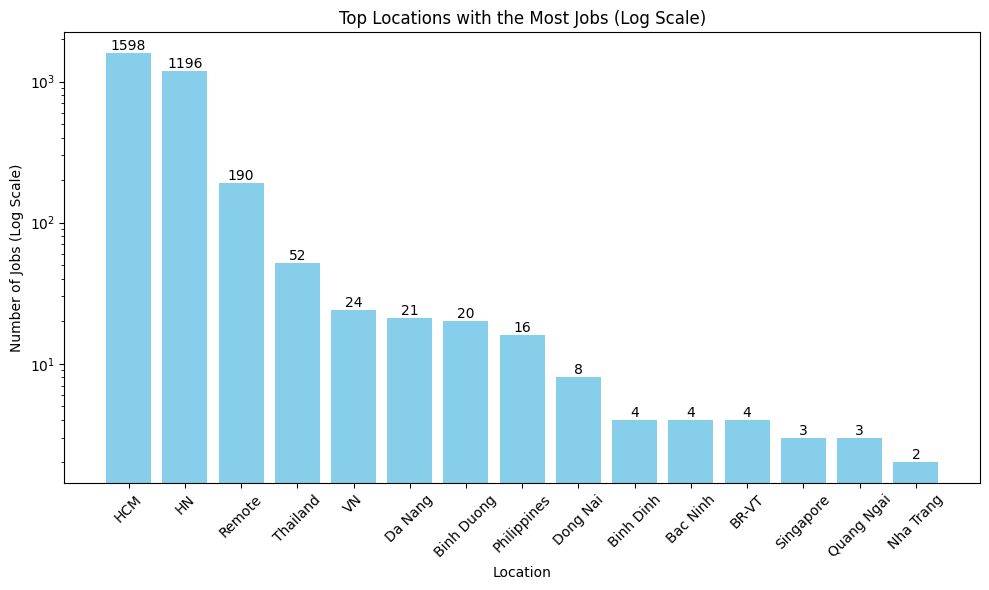

In [10]:
location_counts = test['Location'].value_counts()

# To see the top N locations with the most jobs, you can use:
top_n_locations = location_counts.head(15)

# Create a bar chart with a logarithmic scale on the y-axis and data labels
plt.figure(figsize=(10, 6))
bars = plt.bar(top_n_locations.index, top_n_locations, color='skyblue')

# Add data labels to each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

plt.yscale('log')  # Scale the y-axis by a logarithmic scale
plt.title("Top Locations with the Most Jobs (Log Scale)")
plt.xlabel("Location")
plt.ylabel("Number of Jobs (Log Scale)")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the bar chart
plt.show()


# <a name="II">II. Data analysis</a>
# <a name="II1">1. Finding the most sought after skills</a>

In this step, **we will use NLP techniques to aggregate our job description** in order to see the most frequent skill words for each job.

## <a name="II11">1.1. Skills overview</a>

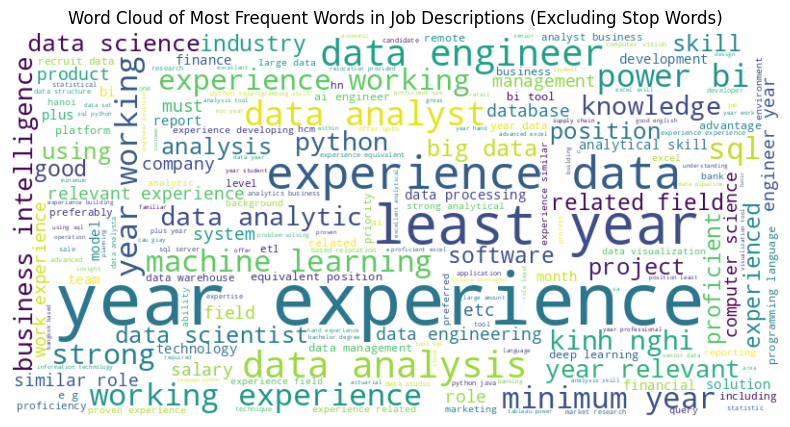

In [11]:
# Combine all job descriptions into a single text
all_descriptions = " ".join(test['JD_Trans'])

# Preprocess the text
all_descriptions = all_descriptions.lower()
all_descriptions = all_descriptions.translate(str.maketrans('', '', string.punctuation))
all_descriptions = "".join(filter(lambda x: not x.isdigit(), all_descriptions))

# Tokenize the text into words
words = nltk.word_tokenize(all_descriptions)

# Remove common stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Specify phrases to keep together
phrases = ["power bi"]

# Tokenize by phrases
for i in range(len(filtered_words)):
    if i < len(filtered_words) - 1 and filtered_words[i] + " " + filtered_words[i+1] in phrases:
        filtered_words[i] = filtered_words[i] + " " + filtered_words[i+1]
        filtered_words[i+1] = ""

# Create a word cloud of the most frequent words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Most Frequent Words in Job Descriptions (Excluding Stop Words)')
plt.show()

**The word cloud looks nice, but contains quite a few redundant words. Let's manually check the list and remove it**

In [12]:
from collections import Counter
# Create a counter to count word frequencies
word_counts = Counter(filtered_words)

# List words by frequency in descending order
sorted_words = [word for word, count in word_counts.most_common()]

# Now you can print the sorted words and choose which ones to remove
for word in sorted_words[:50]:
    print(word)

experience
data
year
least
working
analysis
sql
engineer
business
python
analyst
tool
skill
position
excel
related
analytics
strong
field
role
learning
power bi

minimum
database
management
science
relevant
machine
knowledge
proficient
good
ai
programming
engineering
language
salary
bi
work
analytical
kinh
financial
using
nghi
industry
processing
intelligence
computer
hn
software


It appears some top frequent words are not very meaningful as a skill. Let's manually remove some specific words

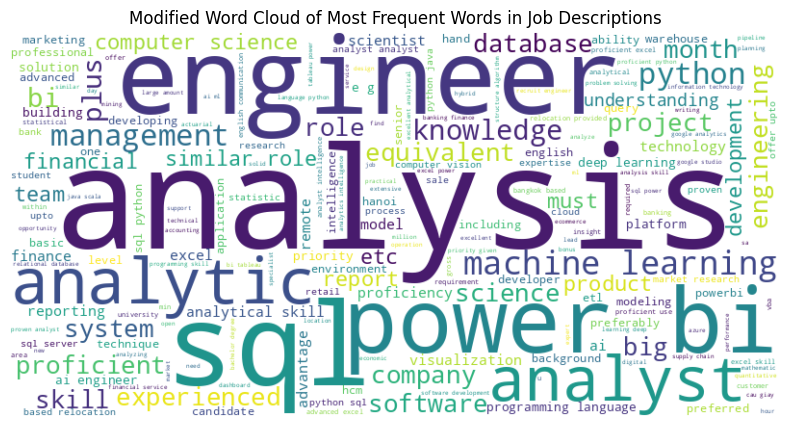

In [13]:
remove_words = ['data','year','least','working','business',
    'tool','position','related','strong','field',
    'minimum','good','salary','work','using','industry',
    'processing','hn','kinh','nghi','experience','relevant'
]

filtered_words = [word for word in filtered_words if word not in remove_words]

# Recreate a word cloud of the modified list of words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))

# Display the modified word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Modified Word Cloud of Most Frequent Words in Job Descriptions')
plt.show()

## <a name="II12">1.2. Skills per job category</a>



While the above analysis gives us a good overview of the skills needed in data career, we'll need to do some NLP for job description analyis to find out what are the skills actually needed for each job type

In [14]:
## For this task, we need a simplified version of the dataframe. jda stands for job description aggregated

jda = test.loc[:, ['Job_ID', 'Job_Title', 'Est_Salary', 'JD_Trans', 'L1','Data_Engineer','Data_Analyst','Data_Scientist','Business_Analyst','Business_Intelligence','Others','Combined_role']]
jda['JD_Trans'] = jda['JD_Trans'].astype(str)


jda = jda[jda['JD_Trans'].str.strip() != '']  # Remove rows with empty 'Trans_JD'


In [15]:
# We can run a NER to recognize the noun (phrases) to search for technical skills. This list of technical skills is derived from that (code will be added later)
technical_skills = [
    'python','r','c','c++','java','hadoop','scala','flask','pandas',
    'spark','scikit','numpy','php','sql','mysql','css','mongodb','nltk',
    'keras','pytorch','tensorflow','linux','ruby','javascript','django',
    'react','reactjs','ai','artificial intelligence','ui', 'skicit',
    'tableau','power bi','machine learning','frontend','big data',
    'data mining','data warehousing','data visualization','data engineering',
    'data modeling','data governance','data analytics','statistical analysis',
    'natural language processing', 'computer vision','deep learning',
    'data preprocessing','etl','data quality management','excel','vba','gcp']


# Create dictionaries to store top 10 technical and soft skills for each category
top_technical_skills = {}
top_soft_skills = {}

top_technical_skill_percentages = {}

# Iterate through each category
categories = ['Data_Engineer', 'Data_Analyst', 'Data_Scientist', 'Business_Analyst', 'Business_Intelligence']
for category in categories:
    # Filter job descriptions for the current category
    descriptions = jda[jda[category] == 1]['JD_Trans']

    # Calculate the total number of job descriptions for this category
    total_jobs = len(descriptions)

    # Create a list to store words from the descriptions for the current category
    category_words = []

    # Tokenize and collect words from the descriptions, excluding remove_words
    for desc in descriptions:
        words = desc.lower().split()
        category_words.extend([word for word in words if word not in remove_words])


    # Count the occurrence of each skill within the current category
    skill_counts = Counter(word for word in category_words if word in technical_skills)

    # Separate technical and soft skills within the current category
    technical = [(skill, count) for skill, count in skill_counts.items() if skill in technical_skills]
    soft = [(skill, count) for skill, count in skill_counts.items() if skill not in technical_skills]

    # Sort skills by count
    technical.sort(key=lambda x: x[1], reverse=True)
    soft.sort(key=lambda x: x[1], reverse=True)

    # Select the top 10 technical skills
    top_technical_skills[category] = [skill for skill, _ in technical[:10]]

    # Select the top 10 soft skills from the sorted list of words
    sorted_words = Counter(category_words).most_common()
    top_soft_skills[category] = [word for word, _ in sorted_words if word not in technical_skills][:10]

# Print the top skills for each category
for category, skills in top_technical_skills.items():
    print(f"Top 10 Technical Skills for {category}: {', '.join(skills)}")

for category, skills in top_soft_skills.items():
    print(f"Top 10 Soft Skills for {category}: {', '.join(skills)}")

Top 10 Technical Skills for Data_Engineer: python, sql, ai, java, etl, spark, c, hadoop, r, scala
Top 10 Technical Skills for Data_Analyst: sql, excel, python, tableau, r, vba, etl, spark, java, c
Top 10 Technical Skills for Data_Scientist: ai, python, pytorch, tensorflow, c, sql, r, java, scala, numpy
Top 10 Technical Skills for Business_Analyst: sql, python, excel, ai, r, tableau, pytorch, scala, java, tensorflow
Top 10 Technical Skills for Business_Intelligence: sql, excel, tableau, python, etl, r, mysql, vba, javascript
Top 10 Soft Skills for Data_Engineer: engineer, engineering, learning, database, programming, machine, knowledge, role, language, software
Top 10 Soft Skills for Data_Analyst: analysis, analyst, bi, skill, analytics, power, management, role, proficient, financial
Top 10 Soft Skills for Data_Scientist: learning, machine, scientist, science, engineer, computer, ml, deep, language, offer
Top 10 Soft Skills for Business_Analyst: scientist, analysis, bi, power, skill, an

**While the technical skills appear to be correct, many soft skills do not appear to be meaningful, such as engineering, machine, skill. I asked ChatGPT to generate a list of soft skills instead**

In [16]:
#A list of soft skills that are needed in general
combined_soft_skills = [
    "Communication", "Critical Thinking", "Creativity","Adaptability", "Teamwork", "Attention to Detail",
    "Time Management", "Emotional Intelligence", "Empathy","Conflict Resolution", "Decision-Making", "Leadership",
    "Problem-Solving", "Ethical Judgment", "Flexibility","Customer Service", "Negotiation", "Innovation",
    "Persuasion", "Resilience", "Collaboration", "Networking","Conflict Management", "Cultural Sensitivity", "Stress Management",
    "Self-Motivation", "Open-Mindedness", "Information Presentation","Risk Management", "Active Listening"
]


## <a name="II13">1.3. Defining helper functions to help aggregate skills into job categories</a>

**For simplicity, we will use the NLP model in spaCy for the purpose of similarity search. Other LLM and their embedding vector can also be utilized here, with the same principle**

As we can seen above, soft skills extracted using basic analysis will miss quite a few synonymn keywords. We need a function to extract soft skills with similar keywords by doing cosine similarity search.

In [17]:
def generate_soft_skill(job_category, job_descriptions, soft_skills):
    # Initialize a dictionary to store relevant skills for each soft skill
    relevant_skills_dict = {}

    for skill in soft_skills:
        # Combine the job descriptions for the specified job category
        category_descriptions = job_descriptions[job_descriptions[job_category] == 1]['JD_Trans']
        all_descriptions = " ".join(category_descriptions)

        # Tokenize the combined string
        words = word_tokenize(all_descriptions)

        # Define stop words
        stop_words = set(stopwords.words('english'))

        # Remove stop words and duplicate words
        filtered_words = [word for word in words if word.lower() not in stop_words]
        unique_words = list(set(filtered_words))

        # Rejoin the unique words into a single string
        processed_description = " ".join(unique_words)

        # Load the processed description into spaCy
        doc = nlp(processed_description)

        # Access individual tokens
        tokens = [token.text for token in doc]

        # Get word vectors for each token
        word_vectors = [token.vector for token in doc]

        # Convert the list of word vectors to a NumPy array
        word_vectors_array = np.array(word_vectors)

        # Initialize a dictionary to store soft skill vectors
        soft_skill_vectors = {}
        skill_doc = nlp(skill)
        soft_skill_vectors[skill] = skill_doc.vector

        # Create a helper function to find top n related soft skills
        def get_top_tokens_for_skill(skill_vector, word_vectors, n=8):
            # Calculate cosine similarity between the skill vector and all word vectors
            similarities = cosine_similarity([skill_vector], word_vectors)[0]

            # Sort the tokens by similarity and get the top N
            top_tokens = [token for token, similarity in sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)[:n]]

            return top_tokens

        # List of all tokens (from the processed description)
        all_tokens = [token.text for token in doc]

        # Create a list to store the top N tokens for the current skill
        top_tokens_for_skill = get_top_tokens_for_skill(skill_doc.vector, word_vectors_array, n=10)

        # Store the relevant skills for the current soft skill in the dictionary
        relevant_skills_dict[skill] = [all_tokens[token] for token in top_tokens_for_skill]

    return relevant_skills_dict

# Example usage:
job_category = 'Data_Engineer'
soft_skills = ['Communication', 'Problem Solving']  # Example soft skills
relevant_skills = generate_soft_skill(job_category, jda, soft_skills)
print("Relevant Skills for Each Soft Skill:")
for skill, relevant_skills_list in relevant_skills.items():
    print(f"{skill}: {relevant_skills_list}")


Relevant Skills for Each Soft Skill:
Communication: ['communication', 'telecommunication', 'telecom', 'implementation', 'integration', 'specialisation', 'organization', 'validation', 'enrichment', 'specialization']
Problem Solving: ['solving', 'problem', 'integrating', 'familiarity', 'understanding', 'implementing', 'elasticsearch', 'optimization', 'computability', 'analytical']


Now we can define a function to find soft skills belong to each job category.

In [18]:
def calculate_soft_skill_occurrences(job_category, job_descriptions, soft_skills):
    # Generate a dictionary of relevant skills for each soft skill
    relevant_skills_dict = generate_soft_skill(job_category, job_descriptions, soft_skills)

    # Combine the job descriptions for the specified job category
    category_descriptions = job_descriptions[job_descriptions[job_category] == 1]['JD_Trans']
    all_descriptions = " ".join(category_descriptions)

    # Tokenize the combined string
    words = word_tokenize(all_descriptions)

    # Define stop words
    stop_words = set(stopwords.words('english'))

    # Remove stop words and duplicate words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    unique_words = list(set(filtered_words))

    # Rejoin the unique words into a single string
    processed_description = " ".join(unique_words)

    # Load the processed description into spaCy
    doc = nlp(processed_description)

    # Create a dictionary to store skill occurrences
    skill_occurrences = {skill: 0 for skill in soft_skills}

    for skill in soft_skills:
        # Include the main skill itself
        skill_occurrences[skill] = all_descriptions.lower().count(skill.lower())

        # Include the occurrences of relevant skills
        if skill in relevant_skills_dict:
            relevant_skills = relevant_skills_dict[skill]
            for relevant_skill in relevant_skills:
                skill_occurrences[skill] += all_descriptions.lower().count(relevant_skill.lower())

    return skill_occurrences

# Example usage:
job_category = 'Data_Engineer'
occurrences = calculate_soft_skill_occurrences(job_category, jda, combined_soft_skills)
sorted_s_occurrences = sorted(occurrences.items(), key=lambda item: item[1], reverse=True)
# Print the sorted skills
print("Soft Skill Occurrences:")
for skill, count in sorted_s_occurrences:
    print(f"{skill}: {count} times")


Soft Skill Occurrences:
Creativity: 239 times
Teamwork: 207 times
Empathy: 182 times
Ethical Judgment: 120 times
Resilience: 105 times
Emotional Intelligence: 103 times
Collaboration: 102 times
Networking: 96 times
Innovation: 85 times
Communication: 82 times
Conflict Management: 82 times
Time Management: 76 times
Problem-Solving: 73 times
Customer Service: 70 times
Information Presentation: 70 times
Critical Thinking: 69 times
Persuasion: 64 times
Cultural Sensitivity: 62 times
Stress Management: 62 times
Conflict Resolution: 61 times
Open-Mindedness: 57 times
Risk Management: 55 times
Active Listening: 55 times
Attention to Detail: 54 times
Negotiation: 53 times
Adaptability: 49 times
Leadership: 48 times
Flexibility: 46 times
Decision-Making: 32 times
Self-Motivation: 32 times


Similar function to find the occurences of the technical skills. For these we need exact search, not similarity search, therefore a dedicated function is preferred

In [19]:
def calculate_tech_skill_occurrences(job_category, job_descriptions, tech_skills):
    # Combine the job descriptions for the specified job category
    category_descriptions = job_descriptions[job_descriptions[job_category] == 1]['JD_Trans']
    all_descriptions = " ".join(category_descriptions)

    # Tokenize the combined string
    words = word_tokenize(all_descriptions)

    # Define stop words
    stop_words = set(stopwords.words('english'))

    # Remove stop words and duplicate words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    unique_words = list(set(filtered_words))

    # Rejoin the unique words into a single string
    processed_description = " ".join(unique_words)

    # Create a Counter to store skill occurrences
    skill_occurrences = Counter()

    for skill in tech_skills:
        # Use regular expressions to find exact matches with word boundaries
        pattern = r'\b{}\b'.format(re.escape(skill))
        matches = re.findall(pattern, all_descriptions, flags=re.IGNORECASE)

        # Count the occurrences of the technical skill
        skill_occurrences[skill] = len(matches)

    return skill_occurrences

# Example usage:
job_category = 'Data_Engineer'

occurrences = calculate_tech_skill_occurrences(job_category, jda, technical_skills)

sorted_occurrences = sorted(occurrences.items(), key=lambda item: item[1], reverse=True)

# Print the sorted skills
print("Technical Skill Occurrences:")
for skill, count in sorted_occurrences:
    print(f"{skill}: {count} times")


Technical Skill Occurrences:
python: 159 times
sql: 123 times
machine learning: 85 times
ai: 84 times
data engineering: 71 times
big data: 53 times
java: 51 times
etl: 46 times
spark: 39 times
c: 32 times
hadoop: 31 times
r: 27 times
scala: 27 times
deep learning: 25 times
computer vision: 19 times
pytorch: 17 times
tensorflow: 16 times
tableau: 16 times
data modeling: 14 times
mysql: 13 times
power bi: 10 times
mongodb: 8 times
data warehousing: 8 times
data analytics: 8 times
excel: 8 times
scikit: 7 times
numpy: 7 times
linux: 7 times
gcp: 5 times
data mining: 4 times
data visualization: 3 times
data governance: 3 times
natural language processing: 3 times
flask: 2 times
php: 2 times
django: 2 times
react: 2 times
artificial intelligence: 2 times
frontend: 2 times
vba: 2 times
javascript: 1 times
statistical analysis: 1 times
data quality management: 1 times
c++: 0 times
pandas: 0 times
css: 0 times
nltk: 0 times
keras: 0 times
ruby: 0 times
reactjs: 0 times
ui: 0 times
skicit: 0 ti

Since skills occurences might vary greatly, it could help pre-defining a min_max_scaling function for later use in word cloud visualization

In [20]:
def min_max_scaling(occurrences):
    # Find the minimum and maximum occurrences
    min_count = min(occurrences.values())
    max_count = max(occurrences.values())

    scaled_occurrences = {}

    # Apply Min-Max scaling
    for skill, count in occurrences.items():
        scaled_count = (count - min_count) / (max_count - min_count)
        scaled_occurrences[skill] = scaled_count

    return scaled_occurrences



## <a name="II14">1.4. Visualize skills by job category</a>

This code is apparently sub-optimized, but it works :)

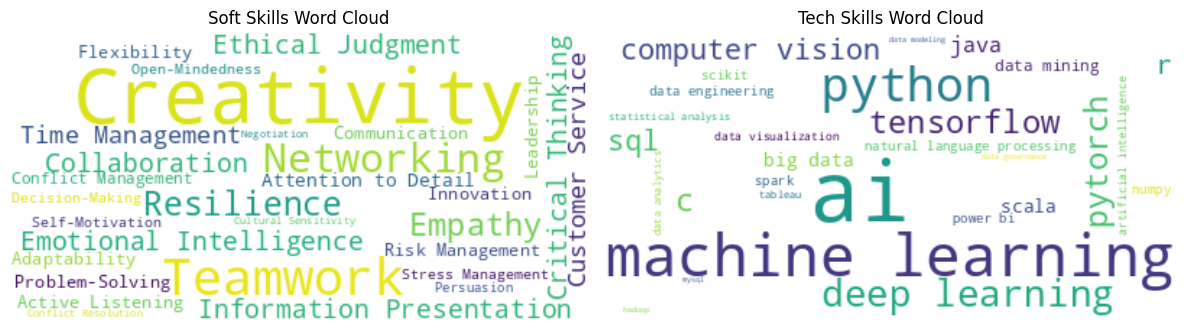

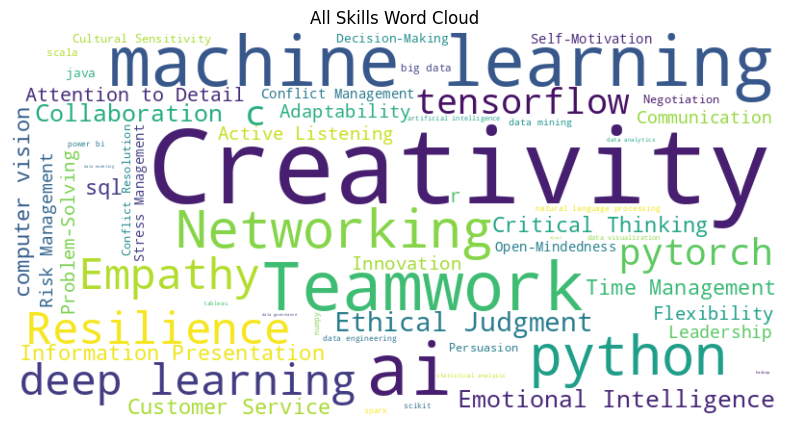

In [21]:

def generate_word_cloud(job_category, job_descriptions, soft_skills, tech_skills, tech_skill_multiplier=2, n=10):
    # Calculate skill occurrences for soft skills
    soft_skill_occurrences = calculate_soft_skill_occurrences(job_category, job_descriptions, soft_skills)
    # Convert soft_skill_occurrences to a dictionary
    soft_skill_frequency_dict = dict(soft_skill_occurrences)

    # Calculate skill occurrences for technical skills
    tech_skill_occurrences = calculate_tech_skill_occurrences(job_category, job_descriptions, tech_skills)

    # Depends on aesthetic and in certain cases, we might need to apply a multiplier to emphasize the importance of technical skills over soft skills
    emphasized_tech_skill_occurrences = {skill: count * tech_skill_multiplier for skill, count in tech_skill_occurrences.items()}

    # Convert emphasized_tech_skill_occurrences to a dictionary
    tech_skill_frequency_dict = dict(emphasized_tech_skill_occurrences)

    # Create a combined dict
    all_skills = {**soft_skill_frequency_dict,** tech_skill_frequency_dict}
    scaled_all_skills = min_max_scaling(all_skills)

    # Create a word cloud based on soft skill frequencies
    soft_skills_wordcloud = WordCloud(width=400, height=200, background_color='white')
    soft_skills_wordcloud.generate_from_frequencies(soft_skill_frequency_dict)

    # Create a word cloud based on technical skill frequencies
    tech_skills_wordcloud = WordCloud(width=400, height=200, background_color='white')
    tech_skills_wordcloud.generate_from_frequencies(tech_skill_frequency_dict)

    # Create a 2x1 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    # Display word clouds in subplots
    axs[0].imshow(soft_skills_wordcloud, interpolation='bilinear')
    axs[0].set_title("Soft Skills Word Cloud")
    axs[0].axis('off')

    axs[1].imshow(tech_skills_wordcloud, interpolation='bilinear')
    axs[1].set_title("Tech Skills Word Cloud")
    axs[1].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the entire figure
    plt.show()

    # Recreate a word cloud of the modified list of words
    all_skills_wordcloud = WordCloud(width=800, height=400, background_color='white')
    all_skills_wordcloud.generate_from_frequencies(scaled_all_skills)

    # Display the modified word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(all_skills_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('All Skills Word Cloud')
    plt.show()


# Example usage:
job_category = 'Data_Scientist'
generate_word_cloud(job_category, jda, combined_soft_skills, technical_skills)


## 2. Job Titles Can Be Deceiving

It's not uncommon for a data specialist to have to perform multiple roles, especially when working for smaller businesses.

Let's examine the job description to understand what roles they are actually expected to fulfill.

We are now going to translate this skill-extraction problem into a classification one first.
And then extract the most important features from each class.

The most important features, in this case, represent the words that most likely will belong to a class ( in our case job category)


**Import some libraries**

In [22]:
#Let's try some ML libraries
!pip install scikit-multilearn

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.preprocessing import MultiLabelBinarizer

jda_clean = jda.dropna(subset=['JD_Trans', 'Data_Engineer', 'Data_Analyst', 'Data_Scientist', 'Business_Analyst', 'Business_Intelligence'])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.7 MB/s eta 0:00:00


<a name="BinaryRelevance">Binary relevance</a>

In [62]:
# Tokenize and build vocabulary
X = vectorizer.fit_transform(jda_clean['JD_Trans'])
y = jda_clean[job_categories]

# Split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
print("Train data shape: ", X_train.shape)
print("y shape: ", y_test.shape)

# Fit the model
br_clf = BinaryRelevance(MultinomialNB())
br_clf.fit(X_train, y_train)

# Predict
y_predicted = br_clf.predict(X_test)

# Evaluate the model
accuracy = br_clf.score(X_test, y_test)
print("Model accuracy:", accuracy)


Train data shape:  (2549, 1000)
y shape:  (638, 5)
Model accuracy: 0.4263322884012539


In [58]:
mlb = MultiLabelBinarizer()

# Preprocess job descriptions
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    lowercase=True,
    token_pattern=r'\w{3,}'
)

# Define your features (X) and target variable (y)
X = vectorizer.fit_transform(jda_clean['JD_Trans'])
y = jda_clean[job_categories]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
print("Train data shape: ", X_train.shape)
print("y shape: ", y_test.shape)

# Create a MultiOutputClassifier with a base classifier (e.g., RandomForest)
rf_clf = MultiOutputClassifier(RandomForestClassifier(random_state=109))

# Fit the model to the training data
rf_clf.fit(X_train, y_train)

# Predict the job categories for the test data
y_pred = rf_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy:", accuracy)

# Print classification report
report = classification_report(y_test, y_pred, target_names=job_categories,zero_division=0)
print("Classification Report:\n", report)

Train data shape:  (2549, 1000)
y shape:  (638, 5)
Model accuracy: 0.5517241379310345
Classification Report:
                        precision    recall  f1-score   support

        Data_Engineer       0.87      0.69      0.77       224
         Data_Analyst       0.77      0.57      0.65       221
       Data_Scientist       0.79      0.52      0.63       101
     Business_Analyst       0.58      0.14      0.23        50
Business_Intelligence       0.80      0.40      0.53        30

            micro avg       0.81      0.56      0.66       626
            macro avg       0.76      0.46      0.56       626
         weighted avg       0.79      0.56      0.65       626
          samples avg       0.51      0.48      0.49       626



In [70]:

# Sample job description
JD = "Strong SQL proficiency, including expertise in writing complex queries and designing data models. Knowledge of big data and Google cloud "

# Vectorize the job description
job_description_vector = vectorizer.transform([JD])

# Manually test the model
predicted = rf_clf.predict(job_description_vector)

# Get the class labels for which the model predicted True
predicted_labels = [job_categories[i] for i, val in enumerate(predicted[0]) if val]

# Print the predicted labels
print("Predicted job categories:", predicted_labels)

Predicted job categories: ['Data_Engineer']


Classification with sigmoid function

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Assuming you have a DataFrame named 'jda' with the columns mentioned
# Separate your data into X (input features) and y (target values)

X = vectorizer.fit_transform(jda_clean['JD_Trans']).toarray()
y = jda_clean[job_categories]

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a neural network model
model = keras.Sequential()
model.add(layers.Input(shape=(X.shape[1],)))  # Input layer with the number of input features
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))  # Output layer with 5 units

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/15
80/80 [==============================] - 2s 11ms/step - loss: 0.5267 - accuracy: 0.3437 - val_loss: 0.4102 - val_accuracy: 0.6426
Epoch 2/15
80/80 [==============================] - 0s 4ms/step - loss: 0.3646 - accuracy: 0.6371 - val_loss: 0.3425 - val_accuracy: 0.6567
Epoch 3/15
80/80 [==============================] - 0s 4ms/step - loss: 0.2945 - accuracy: 0.6591 - val_loss: 0.3181 - val_accuracy: 0.6473
Epoch 4/15
80/80 [==============================] - 0s 4ms/step - loss: 0.2526 - accuracy: 0.6783 - val_loss: 0.3124 - val_accuracy: 0.6332
Epoch 5/15
80/80 [==============================] - 0s 4ms/step - loss: 0.2221 - accuracy: 0.7058 - val_loss: 0.3134 - val_accuracy: 0.6332
Epoch 6/15
80/80 [==============================] - 0s 3ms/step - loss: 0.1976 - accuracy: 0.7211 - val_loss: 0.3242 - val_accuracy: 0.6426
Epoch 7/15
80/80 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.7285 - val_loss: 0.3365 - val_accuracy: 0.6270
Epoch 8/15
80/80 [=

# <a name="CNN">Text Convolution neural network</a>

The prebuilt multi-label classifiers work to a certain degree. Let's see if we can train a manual neural network that can reach the same level of accuracy from scratch.

In [66]:
#Text CNN approach

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define X as the job descriptions (JD_Trans)
X = jda['JD_Trans']

# Define y as the one-hot encoded job categories
y = jda[job_categories]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

train_texts = X_train
test_texts= X_test

# Preprocess your text data and split into train and test sets

# Tokenize text and convert to sequences
tokenizer = Tokenizer(num_words=5000)  # Customize based on your vocabulary size
tokenizer.fit_on_texts(train_texts)
X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to a fixed length (adjust as needed)
X_train = pad_sequences(X_train, maxlen=100)  # Customize the sequence length
X_test = pad_sequences(X_test, maxlen=100)

# Create word embeddings (load pre-trained embeddings or train on your data)
num_labels = 5
# Build the Text-CNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))  # Customize embedding dimensions
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels, activation='sigmoid'))  # Use 'sigmoid' for multi-label classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)


Epoch 1/10
80/80 [==============================] - 4s 39ms/step - loss: 0.4285 - accuracy: 0.4955 - val_loss: 0.3911 - val_accuracy: 0.6113
Epoch 2/10
80/80 [==============================] - 3s 37ms/step - loss: 0.3423 - accuracy: 0.6359 - val_loss: 0.3574 - val_accuracy: 0.6458
Epoch 3/10
80/80 [==============================] - 4s 44ms/step - loss: 0.3027 - accuracy: 0.6618 - val_loss: 0.3462 - val_accuracy: 0.6473
Epoch 4/10
80/80 [==============================] - 3s 38ms/step - loss: 0.2489 - accuracy: 0.6920 - val_loss: 0.3425 - val_accuracy: 0.6442
Epoch 5/10
80/80 [==============================] - 3s 36ms/step - loss: 0.2019 - accuracy: 0.7128 - val_loss: 0.3711 - val_accuracy: 0.6505
Epoch 6/10
80/80 [==============================] - 3s 38ms/step - loss: 0.1695 - accuracy: 0.7403 - val_loss: 0.4101 - val_accuracy: 0.6207
Epoch 7/10
80/80 [==============================] - 5s 58ms/step - loss: 0.1425 - accuracy: 0.7579 - val_loss: 0.4477 - val_accuracy: 0.6552
Epoch 8/10
80

Overall the neural network models accuracy are around 60%, which is not bad considering the low quality of the data job description

In [67]:
# Preprocess and tokenize the new job description(s)
new_job_description = "Strong SQL proficiency, including expertise in writing complex queries and designing data models. Knowledge of big data and Google cloud"
new_job_description_sequence = tokenizer.texts_to_sequences([new_job_description])

# Pad the sequence to have the same length as your training data (if needed)
new_job_description_padded = pad_sequences(new_job_description_sequence, maxlen=100)

# Use the trained CNN model to predict the job categories
predicted_probabilities = model.predict(new_job_description_padded)

# Decode the predicted probabilities to get the job categories
predicted_labels = [job_categories[i] for i, val in enumerate(predicted_probabilities[0]) if val >= 0.4]

# Print the predicted job categories
print("Predicted job categories:", predicted_labels)


1/1 [==============================] - 0s 70ms/step
Predicted job categories: ['Data_Engineer']


We can further improve this network by using the provided Job_title as a point of reference. (Later code will be added)

# <a name="Salary">Salary prediction</a>
Data job analysis will not be completed without a ML model to predict salary

However, this notebook is quite long already, and I would like to establish a detailed approach for salary prediction, therefore it would be appropriate to move to a next notebook
https://colab.research.google.com/drive/14RYJ_lkLIrKZQuKchBHaDXCOKyQGshGH

#Conclusion

In this notebook, we have implemented several methods for extracting skills from a job description using simple NLP techniques. The resulting accuracy is limited due to the reliance on a significant amount of manual inputs for sample technical skills and soft skills.

This problem can be mitigated by employing NER techniques or leveraging a language model (LLM) to extract skills. However, it would require considerably more computational power.

In the skills analysis per job title, it becomes evident that no models can provide a reliable accuracy result. This underscores the low data quality issue, and the fact that minimal effort has been dedicated to data cleaning. It's not surprising that the accuracy of the training model is subpar.

With further data cleaning, especially the removal of duplicates from the original dataset, and the adoption of a more effective skill extraction technique, the model's performance could be significantly improved.

The two example analysis approaches emphasize the importance of selecting the right technique and working with high-quality data to achieve favorable results in machine learning.
